* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch (envelope = abs(hilbert))
* average envelopes

The correct way to do it is to source reconstruct the filtered epochs (not envelope):

compute filtered epochs: xfilt from data x

Compute the beamformer W based on cov(x) or cov(xfilt)

apply beamformer: W xfilt

compute envelope on the source single epoch: |W xfilt|

average enveloped epochs: <|W xfilt|>

plot

which in a formula is s = <|W xfilt|>

In [3]:
import mne
import os
import re
import numpy as np
import sys

os.environ['MNE_3D_OPTION_ANTIALIAS']='false' # to make visualization work

current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils import check_paths

import imageio.v3 as iio

import seaborn as sns

import scipy
import matplotlib.pyplot as plt
from copy import  deepcopy


In [4]:
mne.set_log_level('CRITICAL')

In [2]:
# # create mri dirs in all subs
# #! DON'T LAUNCH ANY MORE

# subs_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
# subs_dir = os.listdir(subs_path)

# for sub_dir in subs_dir:
#     if 'sub' in sub_dir:
#         path = os.path.join(subs_path, sub_dir, 'mri')
#         os.mkdir(path)


Reading D:\Ekaterina_Voevodina\memory_formation\data\subjects\sub2\epochs\enc_epochs.fif ...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_2156\1523021573.py:17: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\subjects\sub2\epochs\enc_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path).pick_types(meg='grad')


    Found the data of interest:
        t =   -1500.00 ...    3995.00 ms
        0 CTF compensation matrices available
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\Ekaterina_Voevodina\memory_formation\data\mri
Subject      = sub2
Surface      = white
Octahedron subdivision grade 6


[Parallel(n_jobs=1)]: Done 42840 out of 42840 | elapsed:    7.6s finished



>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\lh.white...
Mapping lh sub2 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/158411 selected to source space (oct = 6)

Loading D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\rh.white...
Mapping rh sub2 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/151372 selected to source space (oct = 6)

Calculating patch information (limit=0.0 mm)...
    Computing patch statistics...
    Patch information added...
    Computing patch statistics...
    Patch information added...
You

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2883 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1864.0 ms
    4 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...
Checking surface interior status for 4098 points...
    Found 1286/4098 points inside  an interior sphere of radius   46.8 mm
    Found    0/4098 points outside an exterior sphere of radius   92.5 mm
    Found    0/2812 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2812 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1826.5 ms

Checking surface interior status for 204 points...
    Found   0/204 points inside  an interior sphere of radius   46.8 mm
    Found 204/204 points outside an exterior sphere of radius   92.5 mm
    Found   0/  0 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found   0/  0 points outside using solid angles
    Total 0/204 points inside the surface
Interior check completed in 215.2 ms
Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing MEG at 8192 source locations (free orientations)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished



Finished.
<Forward | MEG channels: 204 | EEG channels: 0 | Source space: Surface with 8192 vertices | Source orientation: Free>
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 204 dim * 8.1e+04  max singular value)
    Estimated rank (grad): 204
Found multiple SSS records. Using the first.
    GRAD: rank 204 computed from 204 data channels with 0 projectors
Reducing data rank from 204 -> 204
Estimating covariance using EMPIRICAL


C:\Users\CCDM\AppData\Local\Temp\ipykernel_2156\1523021573.py:44: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (204 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,


Done.
Number of samples used : 62790
[done]
Computing rank from covariance with rank=None
    Using tolerance 4.7e-13 (2.2e-16 eps * 204 dim * 10  max singular value)
    Estimated rank (grad): 80
Found multiple SSS records. Using the first.
    GRAD: rank 80 computed from 204 data channels with 0 projectors


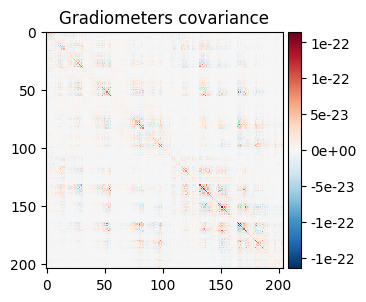

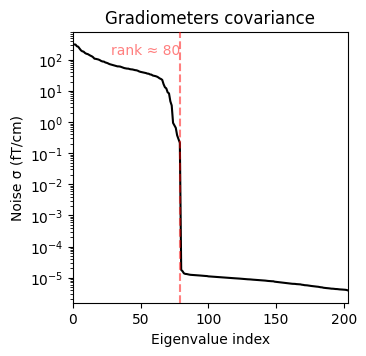

Opening raw data file D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif...
Isotrak not found
    Range : 45000 ... 329999 =     45.000 ...   329.999 secs
Ready.
Reading 0 ... 284999  =      0.000 ...   284.999 secs...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_2156\1523021573.py:50: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using up to 1425 segments


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.2s finished


Number of samples used : 57000
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.9e-14 (2.2e-16 eps * 204 dim * 0.63  max singular value)
    Estimated rank (grad): 68
Found multiple SSS records. Using the first.
    GRAD: rank 68 computed from 204 data channels with 0 projectors


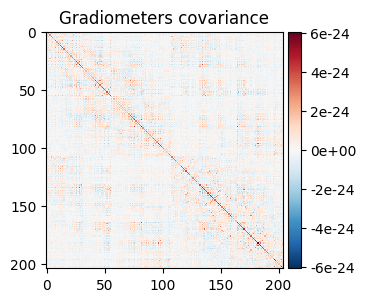

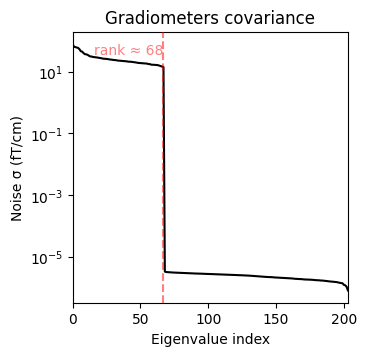

Computing rank from covariance with rank='info'
Found multiple SSS records. Using the first.
    GRAD: rank 80 after 0 projectors applied to 204 channels
0 projection items activated
    GRAD regularization : 0.1
Computing rank from covariance with rank={'grad': 80}
    Setting small GRAD eigenvalues to zero (without PCA)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-14 (2.2e-16 eps * 204 dim * 0.64  max singular value)
    Estimated rank (grad): 80
Found multiple SSS records. Using the first.
    GRAD: rank 80 computed from 204 data channels with 0 projectors


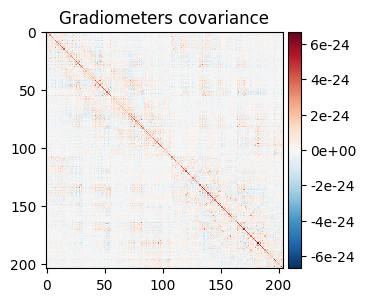

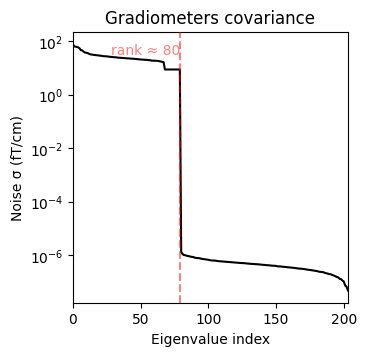

Computing rank from covariance with rank=None
    Using tolerance 4.7e-13 (2.2e-16 eps * 204 dim * 10  max singular value)
    Estimated rank (grad): 80
    GRAD: rank 80 computed from 204 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.9e-14 (2.2e-16 eps * 204 dim * 0.64  max singular value)
    Estimated rank (grad): 80
    GRAD: rank 80 computed from 204 data channels with 0 projectors
Making LCMV beamformer with rank {'grad': 80}
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Whitening the forward solution.
Computing rank from covariance with rank={'grad': 80}
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8192 sources
Filter computation complete


In [4]:
# ONE CELL THAT RULES THEM ALL

# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'
fsaverage_src_path = os.path.join(mris_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')

# dirs to test SR on single subject
subject = 'sub2'
subject_dir = os.path.join(subjects_dir, subject)
# mri_path = os.path.join(mris_dir, subject)
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')

# read epochs and trans files
epochs = mne.read_epochs(epochs_path).pick_types(meg='grad')
info = epochs.info
trans = mne.read_trans(trans_path)

# set frequency bands
epochs_theta = epochs.copy().filter(4., 8.) #.apply_baseline((3.25, 3.75))
# evoked_theta = epochs_theta.average()

# create source space
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=mris_dir)
print(src)

# create BEM model
model = mne.make_bem_model(subject=subject, ico=4, #? ico downsampling
                           conductivity=[0.3], # for single layer - suitable for MEG data
                           subjects_dir=mris_dir)
bem = mne.make_bem_solution(model)

# compute the leadfield matrix / forward operator
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)

# compute data covariance using FULL epochs
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov.plot(epochs.info)

# compute noise covariance from empty room
empty_room_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\empty_room\\empty_room_tsss.fif'
empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)
noise_cov.plot(epochs.info)

noise_cov = mne.cov.regularize(noise_cov, info, mag=0.1, grad=0.1,
                               eeg=0.1, rank='info')
noise_cov.plot(epochs.info)

# create beamformer
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)


**COMPUTING STC**

**&**

**COMPARING BASELINES FOR HITS AND MISSES**

In [ ]:
# apply beamformer to epochs
stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [ ]:
# stc hits and misses
stc_hits = mne.beamformer.apply_lcmv_epochs(epochs_theta['hits'], filters)
stc_miss = mne.beamformer.apply_lcmv_epochs(epochs_theta['miss'], filters)

In [ ]:
# envelope for all epochs
stc_env = deepcopy(stc)
for i in range(len(stc_env)):
    stc_env[i].data = np.abs(scipy.signal.hilbert(stc_env[i].data, N=None, axis=-1))

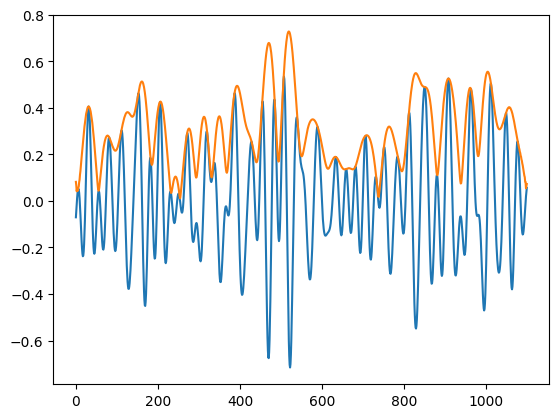

In [10]:
# visualization of the envelope
#! DON'T ADD THIS TO THE FINAL SCRIPT
plt.plot(stc[1].data[0])
plt.plot(stc_env[1].data[0])
plt.show()


In [ ]:
# compute average of the envelope for all epochs
stc_av = deepcopy(stc_env[0])

data = np.array([stc.data for stc in stc_env]).mean(0)
stc_av.data = data

In [33]:
# compute baseline for all trials
bl_all = stc_av.data[:, 950:1040].mean(1)
print('mean:', bl_all.mean(), 'std:', bl_all.std())

mean: 0.9385960970296559 std: 0.4402809264636604


In [6]:
# envelope hits and misses
stc_hits_env = deepcopy(stc_hits)
stc_miss_env = deepcopy(stc_miss)

for i in range(len(stc_hits_env)):
    stc_hits_env[i].data = np.abs(scipy.signal.hilbert(stc_hits_env[i].data, N=None, axis=-1))

for i in range(len(stc_miss_env)):
    stc_miss_env[i].data = np.abs(scipy.signal.hilbert(stc_miss_env[i].data, N=None, axis=-1))

In [7]:
# compute average of the envelope hits and misses
stc_hits_av = deepcopy(stc_hits_env[0])
stc_miss_av = deepcopy(stc_miss_env[0])

data = np.array([stc.data for stc in stc_hits_env]).mean(0)
stc_hits_av.data = data

data = np.array([stc.data for stc in stc_miss_env]).mean(0)
stc_miss_av.data = data

In [16]:
# manually compute baselines for hits and misses
tmin = int(epochs.info['sfreq']*3.25)
tmax = int(epochs.info['sfreq']*3.75)
bl_hits = stc_hits_av.data[:, tmin:tmax].mean(1, keepdims=True)
bl_miss = stc_miss_av.data[:, tmin:tmax].mean(1, keepdims=True)
bl_hits_subset = stc_hits_av.data[
    np.random.choice(len(stc_hits_env), len(stc_miss_env), replace=False),
    tmin:tmax
].mean(1)
bl_all = np.concatenate([bl_hits, bl_miss], 0)
print(
    f'{bl_hits.mean() = : .4f} +- {bl_hits.std() : .4f};\n'
    f'{bl_miss.mean() = : .4f} +- {bl_miss.std() : .4f};\n'
    f'{bl_hits_subset.mean() = : .4f} +- {bl_hits_subset.std() : .4f};\n'
    f'{bl_all.mean() = : .4f} +- {bl_all.std() : .4f}.'
)


bl_hits.mean() =  0.9318 +-  0.4322;
bl_miss.mean() =  0.9033 +-  0.4183;
bl_hits_subset.mean() =  0.5191 +-  0.1836;
bl_all.mean() =  0.9176 +-  0.4255.


In [18]:
bl_all.shape

(16384, 1)

In [20]:
stc_hits_av.data.shape

(8192, 1100)

In [22]:
stc_hits_av.data -= bl_all

ValueError: operands could not be broadcast together with shapes (8192,1100) (16384,1) (8192,1100) 

In [14]:
# manually compute baselines for hits and misses
tmin = int(epochs.info['sfreq']*.5)
tmax = int(epochs.info['sfreq']*.7)
bl_hits = stc_hits_av.data[:, tmin:tmax].mean(1, keepdims=True)
bl_miss = stc_miss_av.data[:, tmin:tmax].mean(1, keepdims=True)
bl_hits_subset = stc_hits_av.data[
    np.random.choice(len(stc_hits_env), len(stc_miss_env), replace=False),
    tmin:tmax
].mean(1)
all_ = np.concatenate([bl_hits, bl_miss], 0) # np.concatenate([bl_hits, np.expand_dims(bl_miss, -1)], 0)
print(
    f'{bl_hits.mean() = : .4f} +- {bl_hits.std() : .4f};\n'
    f'{bl_miss.mean() = : .4f} +- {bl_miss.std() : .4f};\n'
    f'{bl_hits_subset.mean() = : .4f} +- {bl_hits_subset.std() : .4f};\n'
    f'{all_.mean() = : .4f} +- {all_.std() : .4f}.'
)


bl_hits.mean() =  0.9574 +-  0.4592;
bl_miss.mean() =  0.9310 +-  0.4400;
bl_hits_subset.mean() =  0.5229 +-  0.1762;
all_.mean() =  0.9442 +-  0.4499.


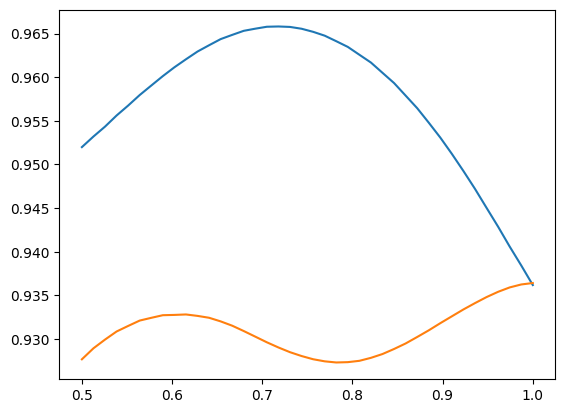

In [15]:
plt.plot(
    np.linspace(0.5, 1., len(stc_hits_av.data[:, tmin:tmax].mean(0))),
    stc_hits_av.data[:, tmin:tmax].mean(0))
plt.plot(
    np.linspace(.5, 1., len(stc_hits_av.data[:, tmin:tmax].mean(0))),
    stc_miss_av.data[:, tmin:tmax].mean(0))

(16384, 1)

In [97]:
epochs['hits']

Number of events,130
Events,enc/neg/hits/notsure: 3enc/neg/hits/sure: 71enc/neu/hits/notsure: 12enc/neu/hits/sure: 44
Time range,-1.500 – 3.995 sec
Baseline,-0.500 – 0.000 sec


-0.0038 +-  0.0665;
-0.0328 +-  0.0939;
-0.0363 +-  0.0375;


In [27]:
# check difference between baselines for all hits vs baseline for all misses
bl_diff = bl_hits - bl_miss
print('means:', 'hits :', bl_hits.mean(), 'miss :', bl_miss.mean(), 'diff :', bl_diff.mean())
print('std:', 'hits :', bl_hits.std(), 'miss :', bl_miss.std(), 'diff :', bl_diff.std())

means: hits : -0.0037834733041371372 miss : -0.03284729944746665 diff : 0.02906382614332953
std: hits : 0.06646716809888002 miss : 0.09392563680593224 diff : 0.11506480645481745


In [23]:
# BASELINING
stc_hits_av.data -= bl_hits
stc_miss_av.data -= bl_hits
stc_diff = stc_hits_av - stc_miss_av

In [ ]:
stc_hits_av.data -= bl_all

In [44]:
# randomly pick a number of epochs from hits equal to number of epochs in misses
array = np.random.choice(len(stc_hits_env), len(stc_miss_env), replace=False)
new_stc_hits_env = np.array(stc_hits_env)[array]

In [46]:
# compute average of the envelope of equal number of hits and misses
new_stc_hits_env_av = deepcopy(new_stc_hits_env[0])

data = np.array([stc.data for stc in new_stc_hits_env]).mean(0)
new_stc_hits_env_av.data = data

# compute baselines for equal number of hits (based on num of misses)
new_bl_hits = new_stc_hits_env_av.data[:, int(epochs.info['sfreq']*3.25):int(epochs.info['sfreq']*3.75)].mean(1)

In [32]:
new_bl_hits = new_stc_hits_env_av.data[:, int(epochs.info['sfreq']*3.25):int(epochs.info['sfreq']*3.75)].mean(1)

In [56]:
hits = stc_hits_av.data[array, int(epochs.info['sfreq']*3.25):int(epochs.info['sfreq']*3.75)].mean()

In [57]:
hits

-0.03599959945514187

In [53]:
bl_hits.mean()

-0.03599959945514186

In [51]:
data = np.array([stc.data for stc in new_stc_hits_env])
data[:, int(epochs.info['sfreq']*3.25):int(epochs.info['sfreq']*3.75)].mean()

1.0929120925671274

In [47]:
# check difference between baselines for equal number of hits and misses
new_bl_diff = new_bl_hits - bl_miss

print('means:', 'equal hits -', new_bl_hits.mean(), 'miss -', bl_miss.mean(), 'diff -', bl_diff.mean())
print('std:', 'equal hits -', new_bl_hits.std(), 'miss -', bl_miss.std(), 'diff -', bl_diff.std())

means: equal hits - 0.9605348460705656 miss - -0.03284729944746665 diff - 0.02906382614332953
std: equal hits - 0.433787904125167 miss - 0.09392563680593224 diff - 0.11506480645481745


In [ ]:
# apply baseline to envelope
#????????
#! MEMORY ERROR

stc_env_bl = deepcopy(stc_env)#.apply_baseline(baseline=(3.25, 3.75))
data = np.array([stc.data for stc in stc_env]) # shape ~ n_epochs x n_sources x n_times
mne.baseline.rescale(data, stc_env[0].times, (3.25, 3.75), copy=False)

for stc, stc_course in zip(stc_env_bl, data):
    stc.data = stc_course
plt.plot(np.array([stc.data for stc in stc_env_bl]).T)
plt.show()


In [1]:
epochs

NameError: name 'epochs' is not defined

In [ ]:
# compute average of the envelope in source space
stc_env_bl_av = deepcopy(stc_env_bl[0])

data = np.array([stc.data for stc in stc_env_bl]).mean(0)
stc_env_bl_av.data = data

In [9]:
# visualization of the source estimates
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

#! check the variable name below
fig = stc_diff.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)

Using pyvistaqt 3d backend.



Using control points [0.23630153 0.26561137 0.45095074]


**SAVING**

In [ ]:
## to save for each subject

# set dir to save source files
source_dir = os.path.join(subject_dir, 'source_rec')
check_paths(source_dir)

# set path and name for each file
src_path = os.path.join(source_dir, f'src_{subject}')
bem_path = os.path.join(source_dir, f'bem_{subject}')
fwd_path = os.path.join(source_dir, f'fwd_{subject}')
data_cov_path = os.path.join(source_dir, f'data_cov_{subject}')
noise_cov_path = os.path.join(source_dir, f'noise_cov_{subject}')
filters_path = os.path.join(source_dir, f'lcmv_beamformer_{subject}.h5')

# save files
src.save(src_path, overwrite=True)
mne.write_bem_solution(bem_path, bem, overwrite=True)
mne.write_forward_solution(fwd_path, fwd, overwrite=True)
mne.write_cov(data_cov_path, data_cov, overwrite=True)
mne.write_cov(noise_cov_path, noise_cov, overwrite=True)
filters.save(filters_path, overwrite=True)


In [ ]:
## to save for each condition and each freq band in each subject
# save averaged baselined source estimates
stc_path = os.path.join(source_dir, f'stc_{subject}')
stc_av.save(fname=stc_path, ftype='h5', overwrite=True)


In [139]:
theta = (4., 8.)
x, y = theta
print(x, y)

4.0 8.0


In [141]:
# set frequency bands
theta = (4., 8.)
alpha = (8., 15.)
beta = (15., 30.)
gamma = (30., 60.)
freq_bands = [theta, alpha, beta, gamma]

for freq_band in freq_bands:
    x, y = freq_band
    epochs_filt = epochs.copy().filter(x, y)
    print(epochs_filt)

<EpochsFIF |  210 events (all good), -1.5 - 3.995 sec, baseline -0.5 – 0 sec, ~364.6 MB, data loaded,
 'enc/neu/miss/notsure': 19
 'enc/neg/miss/sure': 19
 'enc/neg/miss/notsure': 15
 'enc/neu/hits/sure': 44
 'enc/neg/hits/sure': 71
 'enc/neu/hits/notsure': 12
 'enc/neu/miss/sure': 27
 'enc/neg/hits/notsure': 3>
<EpochsFIF |  210 events (all good), -1.5 - 3.995 sec, baseline -0.5 – 0 sec, ~364.6 MB, data loaded,
 'enc/neu/miss/notsure': 19
 'enc/neg/miss/sure': 19
 'enc/neg/miss/notsure': 15
 'enc/neu/hits/sure': 44
 'enc/neg/hits/sure': 71
 'enc/neu/hits/notsure': 12
 'enc/neu/miss/sure': 27
 'enc/neg/hits/notsure': 3>
<EpochsFIF |  210 events (all good), -1.5 - 3.995 sec, baseline -0.5 – 0 sec, ~364.6 MB, data loaded,
 'enc/neu/miss/notsure': 19
 'enc/neg/miss/sure': 19
 'enc/neg/miss/notsure': 15
 'enc/neu/hits/sure': 44
 'enc/neg/hits/sure': 71
 'enc/neu/hits/notsure': 12
 'enc/neu/miss/sure': 27
 'enc/neg/hits/notsure': 3>
<EpochsFIF |  210 events (all good), -1.5 - 3.995 sec, bas

**ADDITIONAL**

NO DIFFERENCE BTW ENV -> BASELINE -> AVERAGE

AND

ENV -> AVERAGE -> BASELINE

*shown on source estinetes and epochs*

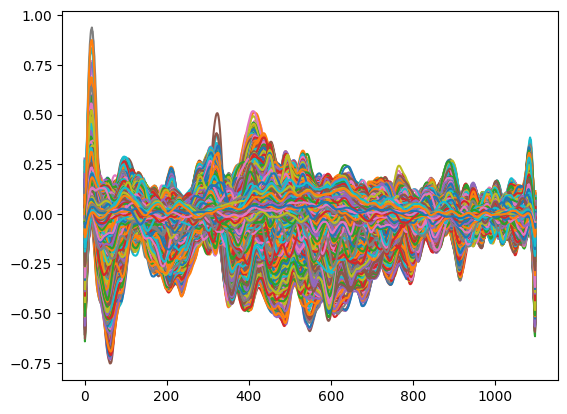

In [ ]:
data = np.array([stc.data for stc in stc_env_bl])
plt.plot(data.mean(0).T)
plt.show()

Applying baseline correction (mode: mean)


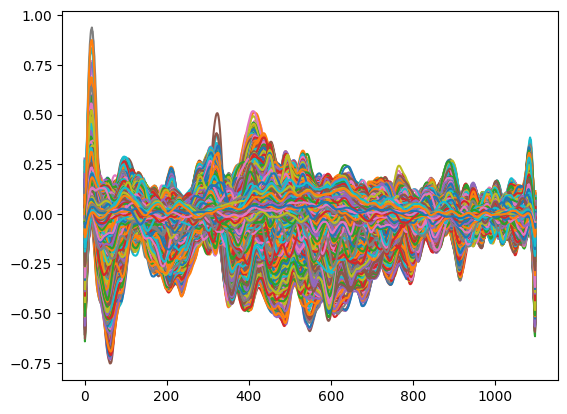

In [ ]:
stc_env_averaged_bl = deepcopy(stc_env_av).apply_baseline(baseline=(3.25, 3.75))
plt.plot(stc_env_averaged_bl.data.T)
plt.show()

Applying baseline correction (mode: mean)


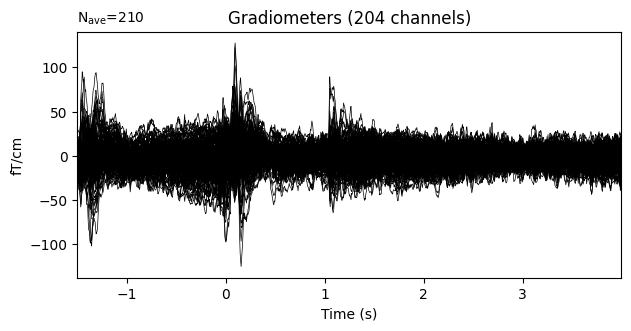

In [ ]:
epochs_cp = epochs.copy()
fig = epochs_cp.apply_baseline((0, 1)).average().plot()

Applying baseline correction (mode: mean)


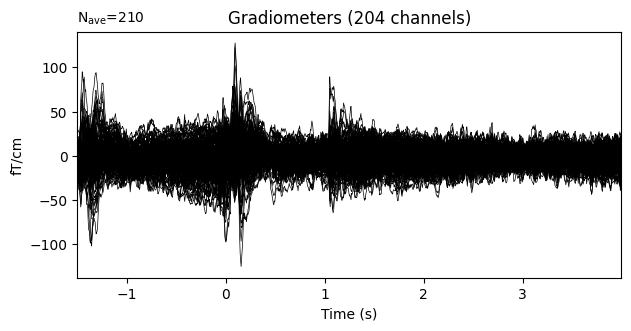

In [ ]:
epochs_cp = epochs.copy()
fig = epochs_cp.average().apply_baseline((0, 1)).plot()

In [ ]:
# # directories to work with
#! PROBABLY I DON'T NEED THIS ANYMORE
# #! LAUNCH ONLY FOR GROUP ANALYSIS
# subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
# mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'

# for subject in os.listdir(subjects_dir):
#     subject_path = os.path.join(subjects_dir, subject)
#     # mri_path = os.path.join(mris_dir, subject)
#     trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')
#     epochs_dir = os.path.join(subject_path, 'epochs')
#     epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
#     # epochs = mne.read_epochs(epochs_path)
#     # trans = mne.read_trans(trans_path)


**VISUALIZATION OF MODELS AND SOURCE SPACE**

In [ ]:
# # visualize evoked
# #! DON'T ADD TO THE FINAL SCRIPT

# evoked_theta.copy().crop(-0.5, 1.5).plot_joint()
# evoked_alpha.copy().crop(-0.5, 1.5).plot_joint()
# evoked_beta.copy().crop(-0.5, 1.5).plot_joint()
# evoked_gamma.copy().crop(-0.5, 1.5).plot_joint()

In [ ]:
# # visualize BEM surfaces
# #! DON'T ADD TO THE FINAL SCRIPT

# plot_bem_kwargs = dict(
#     subject=subject, subjects_dir=mris_dir,
#     brain_surfaces='white', orientation='coronal')

# mne.viz.plot_bem(src=src, **plot_bem_kwargs)


In [ ]:
# # visualization of sources in 3d
# #! DON'T ADD TO THE FINAL SCRIPT

# fig = mne.viz.plot_alignment(subject=subject, subjects_dir=mris_dir,
#                              surfaces='white', coord_frame='mri',
#                              src=src)
# mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
#                     distance=0.30, focalpoint=(-0.03, -0.01, 0.03))


In [ ]:
# # check number of vertices
# #! DON'T ADD TO THE FINAL SCRIPT

# print(f'Before: {src}')
# print(f'After:  {fwd["src"]}')

# # numpy array containing gain matrix
# leadfield = fwd['sol']['data']
# print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# # numpy array containing the forward operator corresponding to the source space
# #! DON'T ADD TO THE FINAL SCRIPT

# fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
#                                          use_cps=True)
# leadfield = fwd_fixed['sol']['data']
# print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# #! DON'T ADD TO THE FINAL SCRIPT

# mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
#                        meg=['helmet', 'sensors'], subjects_dir=mris_dir,
#                        surfaces='head-dense')

**VISUALIZATION OF SOURCES. ADDITIONAL**

In [ ]:
# LCMV beamformes on theta epochs and then averaging
#! Issues with visualization (but the computations should be correct)
stc_epochs_theta = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)
stc_epochs_theta_averaged = sum(stc_epochs_theta) / len(stc_epochs_theta)

stc_epochs_theta_averaged_viz = stc_epochs_theta_averaged.copy()
stc_epochs_theta_averaged_viz.data = stc_epochs_theta_averaged_viz.data / 1000

In [ ]:
#! ONLY for visualization of source estimates ALL and HITS-MISS in theta
# stc_viz = stc.copy()
# stc_diff_viz = stc_diff.copy()
# stc_viz.data = stc_viz.data / 1000
# stc_diff_viz.data = stc_diff_viz.data / 1000

# visualize source estimates ALL
# lims = [0.3, 0.45, 0.6]
# kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
#               initial_time=None, verbose=True)

# fig = stc_viz.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)